# Coursework for PA4611

This notebook contains coursework for PA4611 "Computational Fluid and Phase-Space Flows" at University of Leicester.

This piece of course is the first half of the second computational project. It is focussed on computational hydrodynamics, in this case using the method of Smoothed Particle Hydrodynamics (SPH) to simulate the flow of a fluid in a 1D. Please refer to the associated slides for some key science and theory.

## Rules and guidelines for the project

This Jupyter notebook, completed, is all that you need to submit. 

The work must be your own, and you may not source answers from other people or online resources. You may use the course notes, lecture slides, and software documentation or other general information available online (i.e., not specific to these questions).

You may not use generative AI to solve the problems. You can use it to do simple tasks with Python (for example, to generate initial conditions for the pendulum task). If so you must clearly document in this notebook which steps were done with the help of AI and which were done by you.

The mark for each question will be based on whether the solutions are correct, whether the plots are clear and well-labelled, whether the code runs correctly and is not unnecessarily repetitive, and whether requested text answers are complete, correct and well reasoned.

The below notebook cells include some basic code which you should use as a starting point, but you will fill in the rest yourself. Also answer any questions in the text box (i.e., markdown cell) they are asked in. Feel free to add extra cells at any point in the notebook if needed.

The notebook you hand in should do all its calculations and plotting when run from start to finish. It should not rely on any external files or data. Check that this is the case before submitting ("Restart and Run All" in Jupyter should help you check this).

## Mark scheme

TBD

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

## Some important Python knowledge

You have been using numpy arrays of values to do your work within this course. There are some very useful ways of accessing the values contained in them that you should be aware of. I'll show a few below.

### Array slicing

In [5]:
a = np.array([7,8,4,2,5,9])

# You can pick out a single value
print("The first item is", a[0], ", note that this has the index 0")
print("The last item is", a[5], "or, equivalently,", a[-1], ", note that I can access this with index -1")

The first item is 7 , note that this has the index 0
The last item is 9 or, equivalently, 9 , note that I can access this with index -1


In [6]:
# You can pick out a range of values
print("The first three items are", a[0:3])
print("The last three items are", a[-3:])

The first three items are [7 8 4]
The last three items are [2 5 9]


One really useful way of using this is to find the differences between successive values in an array. This is useful for finding the gradient of a function, for example. Here's some example code:

In [7]:
x = np.array([1,2,3,4,5,6,7])
y = x**2
print("The difference between successive values of y is", y[1:] - y[:-1])
print("The difference between successive values of x is", x[1:] - x[:-1])
print("The average of successive values of x is", 0.5*(x[1:] + x[:-1]))
print("Note that these are all one shorter than the original arrays")


The difference between successive values of y is [ 3  5  7  9 11 13]
The difference between successive values of x is [1 1 1 1 1 1]
The average of successive values of x is [1.5 2.5 3.5 4.5 5.5 6.5]
Note that these are all one shorter than the original arrays


### Setting conditions: Boolean indexing

In [8]:
# I can also set a condition, or multiple conditions, and only pick out values where that is true
print("The values greater than 5 are", a[a>5])
print("The values greater than three but less than 8 are", a[(a>3) & (a<8)])

The values greater than 5 are [7 8 9]
The values greater than three but less than 8 are [7 4 5]


In [9]:
# I can use that syntax to set values to other arrays, so, for example

b = np.zeros(len(a)) # set up an array of zeros the same length as a
b[a>5] = 1 # set the values of b to 1 where the values of a are greater than 5
print("The values of b are", b)

The values of b are [1. 1. 0. 0. 0. 1.]


In [10]:
# Or even
b = np.zeros(len(a))
b[a>5] = a[a>5] # set the values of b to the values of a where the values of a are greater than 5
print("The values of b are", b)

The values of b are [7. 8. 0. 0. 0. 9.]


In [11]:
# Note that the version in this cell will NOT work
b[a>5] = a

ValueError: NumPy boolean array indexing assignment cannot assign 6 input values to the 3 output values where the mask is true

# The SPH kernel

The SPH kernel that we will be using is defined in the lecture slides and in the slides for this coursework. It is a cubic spline kernel.


You need to implement this kernel as a function in Python. You should calculate the kernel and its gradient with respect to the distance between two particles.

You should then check that you have calculated both of these correctly. You should compare to the plot in the slides, which includes checking that the gradient is correct by comparing to a simple numerical derivative.



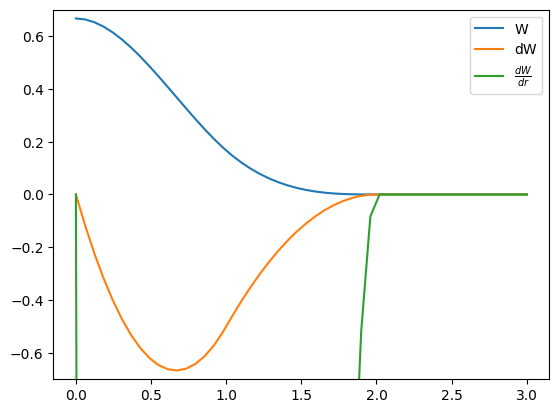

In [42]:
def calculate_kernel(r, smoothing_length):
    '''Calculate the kernel function, W, for an input array of distances r and a smoothing length h'''
    h = smoothing_length
    c = 2/3
    nu = 1
    W = np.zeros(len(r))
    cond1 = (0<=r) & (r < h)
    W[cond1] = (2/(3*h))*(1 - 3/2*(r[cond1]/h)**2 + 3/4*(r[cond1]/h)**3)

    cond2 = (h <= r) & (r < 2*h)
    W[cond2] = (2/(3*h))*(1/4*(2-r[cond2]/h)**3)

    cond3 = r >= 2
    W[cond3] = 0
    
    return W

def calculate_kernel_derivative(r, smoothing_length):
    h = smoothing_length
    '''Calculate the derivative of the kernel function, W, wrt r for an input array of distances r and a smoothing length h'''
    dW = np.zeros_like(r)
    cond1 = (0<=r) & (r < h)
    dW[cond1] = (2/(3*h))*((-3*r[cond1])/(h**2) + (9/4)*(r[cond1]**2/h**3))

    cond2 = (h <= r) & (r < 2*h)
    dW[cond2] = (2/(3*h))*(-3/(4*h))*(2-r[cond2]/h)**2

    cond3 = r >= 2*h
    dW[cond3] = 0
    
    return dW

r = np.linspace(0,3)

# Calculate W and dW/dr for h=1
Kernel = calculate_kernel(r, smoothing_length = 1)
derivative = calculate_kernel_derivative(r, smoothing_length = 1)
# Calculate the numerical derivative of W i.e. Delta W/Delta r for some small Delta r
num_der = np.array(derivative)
num_der = num_der/0.01
# Plot all three and compare to slides

plt.plot(r, Kernel, label = 'W')
plt.plot(r, derivative, label = 'dW')
plt.plot(r, num_der, label = r'$\frac{dW}{dr}$')
plt.ylim([-0.7, 0.7])
plt.legend()

## Initial conditions

I've set these up for you below. They are the same as in the slides. You should use these initial conditions for the rest of the coursework.

In [1]:
particle_mass = 0.001875
tube_size = 0.6
total_n = 400

def set_initial_conditions():

    first_partition_n = int(0.8 * total_n)
    pos = np.zeros(total_n)

    pos[:first_partition_n] = np.linspace(-tube_size, 0, first_partition_n, endpoint=False)
    pos[first_partition_n:] = np.linspace(0, tube_size, total_n - first_partition_n, endpoint=False)

    # initial velocity = 0
    vel = np.zeros(total_n)

    initial_e_val = (2.5, 1.795)
    #initial_p_val = (1, 0.1795)
    initial_rho_val = (1, 0.25)

    energy = np.ones(total_n)
    energy[:first_partition_n] = initial_e_val[0]
    energy[first_partition_n:] = initial_e_val[1]

    density = np.ones(total_n)
    density[:first_partition_n] = initial_rho_val[0]
    density[first_partition_n:] = initial_rho_val[1]
    return pos, density, vel, energy


# Make sure you reset before running any code or tests!
pos, density, vel, energy  = set_initial_conditions()

NameError: name 'np' is not defined

# Implementing a 1D SPH code

The basic equations that you need to solve are given in the slides. You should implement these in Python. For your first attempt do not include any artificial viscosity. We will return to that later.

You need to calculate the effect on each particle of all other particles. I see two methods of doing this, and I think either is valid. Chose which one you are more comfortable with.

First, you could loop over all particles, and for each particle calculate the effect of all other particles. This is the most straightforward way of doing it, but it is also the slowest. A pseudocode version of this is:

```
def calculate(INPUTS):
    pressure = energy * (gamma - 1) * density
    density_derivative = np.zeros(Number_of_particles)
    # Similar for velocity & energy

    for i in range(Number_of_particles): 
        # Calculate vector of differences between particle i and all other particles
        position_difference = position[i] - position
        # Calculate the derivative of the kernel function for each particle
        # Be sure to ensure that the sign of the derivative is correct

        # Similarly for the velocity
        velocity_difference = velocity[i] - velocity

        density_derivative[i] = sum(velocity_difference * mass * kernel_derivative_term)
        etc
        return density_derivative, etc
```


Alternatively you could use numpy broadcasting to do all the particles at once rather than using a loop. This is a bit harder to follow, but may be somewhat faster. A pseudocode version of this is:

```
def calculate(INPUTS):
    pressure = energy * (gamma - 1) * density
    position_difference = position[:, np.newaxis] - position[np.newaxis, :]

    etc
    density_derivative = sum(velocity_difference * mass * kernel_derivative_term, axis=1)

    return density_derivative, etc
```

## SPH without artificial viscosity

In [2]:
def calculate_derivatives(pos, density, vel, energy, smoothing_length):
    '''Calculate the derivatives of the state variables density, velocity and energy 
     
    Inputs are a set of positions, densities, velocities and energies, and the
    smoothing length, but note that since you are using a leapfrog integrator, 
    you don't need to calculate the derivative of position'''
    # Fill in this function yourself
    return


def leapfrog(pos, density, vel, energy, dt, smoothing_length):
    '''Take a single leapfrog step'''
    # Fill in this function yourself
    # Things to do:
    #   Step positon forwards by 0.5*vel*dt
    #   Calculate the derivatives using these new positions
    #   Step velocity, density, energy, forwards by dt with these new derivatives
    #   Step position forwards by 0.5*vel*dt
    return # the new values of pos, density, vel, energy



## Run a simulation

Set up a simulation with the initial conditions given above. Run the simulation with $dt=0.002$ for 100 steps. Plot the density, velocity and pressure of the particles as a function of position for a few different times during the simulation.

Be aware that you can expect significant oscillation around the expected solution. This is due to the numerical solution we are using. The oscillations should reduce over time, but are also reduced with 


In [ ]:
# Run a simulation
pos, density, vel, energy  = set_initial_conditions()

# Your bit:


### You have control of numerical parameters of your simulation (most simply, timestep or smoothing length)

Adjust one or more of these and look at the results. Describe what you have done and your results. Use as many markdown or Python cells as you need to do this. 

# SPH with artificial viscosity

Final step. Implement artificial viscosity in your code.

This is a bit more complicated than the previous steps. Many of you will not get to this point, and that is OK. You will still get a good mark if you have done the previous steps well.